In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
data = pd.read_csv("dataset/anaemia.csv")

In [5]:
data['Sex'] = data['Sex'].str.strip()

missing_values = data.isnull().sum()

duplicates = data.duplicated().sum()
data = data.drop_duplicates()

In [6]:
encoder = LabelEncoder()

data['Sex'] = encoder.fit_transform(data['Sex'])

data['Anaemic'] = encoder.fit_transform(data['Anaemic'])

In [7]:
data["Anaemic"]

0      1
1      0
2      0
3      0
4      0
      ..
99     1
100    1
101    0
102    0
103    0
Name: Anaemic, Length: 104, dtype: int64

In [8]:
X = data[['Sex', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']]
y = data['Anaemic']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for SVM
scaler = StandardScaler()

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

In [10]:
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, random_state=42)

In [11]:
svm_predictions = svm_model.predict(X_test_scaled)

In [12]:
svm_report = classification_report(y_test, svm_predictions)
svm_confusion = confusion_matrix(y_test, svm_predictions)

print(svm_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [13]:
svm_confusion

array([[16,  0],
       [ 0,  5]])

# Analisis SHAP

In [14]:
import seaborn as sns
import shap
shap.initjs()

/Users/guillermosantosbarrios/Developer/Universidad/2024/ResponsibleAI/AnaemiaPredictionEDA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SHAP Values

In [15]:
callable_model = lambda x: svm_model.predict(x)
explainer = shap.Explainer(callable_model, X_train_scaled)
shap_values = explainer(X_test_scaled)
shape_of_shap_values = shap_values.values.shape	
shape_of_shap_values

(21, 5)

## SHAP Summary Plot

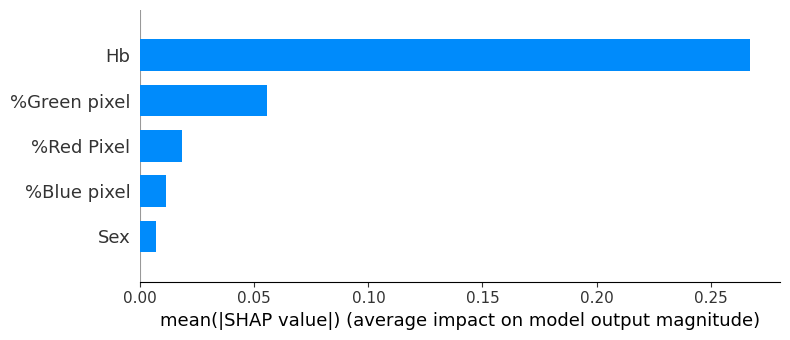

In [21]:
# Shap summary plot
shap.summary_plot(shap_values, X_test_scaled, plot_type='bar')

La variable hb es la que más influye en el modelo.

## SHAP Dependence Plots

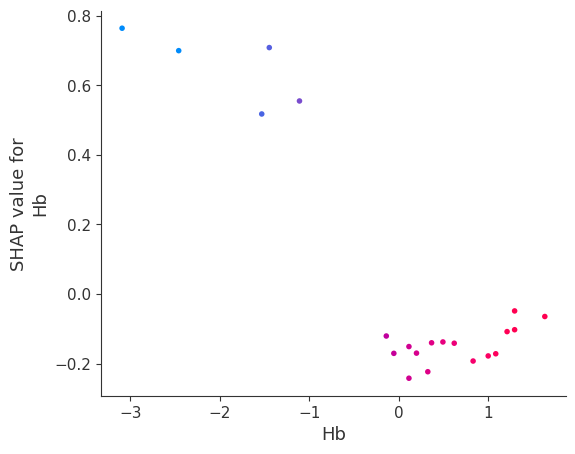

In [29]:
# Shap dependence plots - hb
shap.dependence_plot('Hb', shap_values.values, X_test_scaled, interaction_index='Hb')

El gráfico muestra una tendencia clara donde los valores más bajos de Hb tienen un impacto positivo fuerte en la salida del modelo, mientras que los valores más altos de Hb tienen un impacto negativo. Esto podría indicar que el modelo está diseñado para predecir salidas más altas para valores bajos de Hb y salidas más bajas para valores altos de Hb.

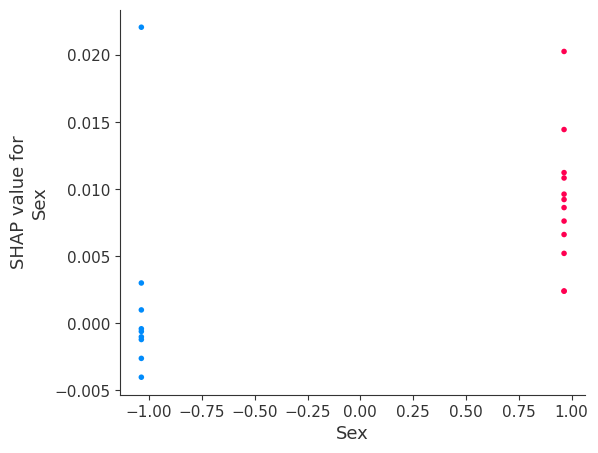

In [30]:
shap.dependence_plot('Sex', shap_values.values, X_test_scaled, interaction_index='Sex')

Dado que los valores SHAP varian entre -0.005 y 0.02, el impacto de la variable Sex en la salida del modelo es relativamente pequeño en comparación con otras variables.

## SHAP Force Plots

In [36]:
# Shap force plots
shap.plots.force(shap_values)

La característica "Hb" tiene una influencia variable en las predicciones del modelo: en muchos casos, reduce ligeramente la predicción, pero en un conjunto específico de muestras, tiene un impacto positivo fuerte. Es posible observar que otras variables no contribuyen significativamente al modelo.

### SHAP Beeswarm

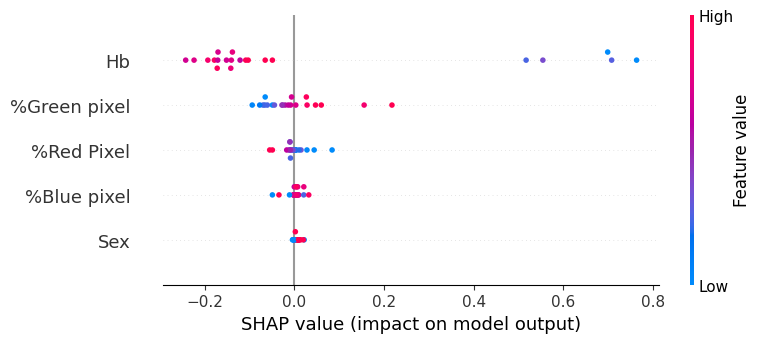

In [34]:
shap.plots.beeswarm(shap_values)

Con esto confirmamos que el impacto en el output del modelo de la variable Hb es el más significativo, por otra parte otras variables permaneces cercnas a 0. Asimismo un alto valor en Hb es explicado por un menor valor SHAP. 